# 04. Adv DQN example with CartPole

## Colab 용 package 설치 코드

In [ ]:
!pip install gym
!pip install JSAnimation

### package import

In [1]:
# The typical imports
from IPython.display import clear_output
import gym
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

import tensorflow as tf

np.random.seed(777)
tf.set_random_seed(777)
random.seed(777)

print("tensorflow version: ", tf.__version__)
print("gym version: ", gym.__version__)

tensorflow version:  1.8.0
gym version:  0.11.0


### 게임 화면을 보여주기 위한 함수

In [2]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

### 그래프를 그리기 위한 함수

In [3]:
def plot(frame_idx, episode, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.4/MathJax.js?config=TeX-MML-AM_CHTML' async></script>
## CartPole
CartPole is game that ballance pole on the car.  
this game's observation is $x$, $x\prime$, $\theta$, $\theta\prime$

$x$ : 카트의 위치  
$\theta$ : 막대의 각도  
$x\prime$ : 카트의 속도  
$\theta\prime$ : 막대의 각속도  

Action is **Left** or **Right**  

모든 step 마다 보상을 1 받으며, 아래 3가지 경우에 episode가 끝난다.
1. 카트가 바깥으로 나갈 때
2. 기둥이 너무 많이 기울었을 때
3. 200 step 지났을 때  
<img src="./img/cartpole.gif" width="60%" align="left"> 

In [4]:
# CartPole 환경
env_id = "CartPole-v0"
env = gym.make(env_id)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print("Observation size : ", state_size)
print("Action size : ", action_size)

Observation size :  4
Action size :  2


## Adv DQN Agent

### Prioritized Replay Buffer
TD error를 같이 저장해서 우선순위를 결정한다.  
$\alpha$는 hyperparameter로 우선순위를 얼마나 적용할 건지 결정한다. 0이면 uniform sample이다.  
<img src="./img/PER.png" width="30%" align="left"> 

$\epsilon$은 TD error가 0일 경우 확률이 0이 되버리기 때문에 그것을 방지하는 작은 상수이다.  
<img src="./img/PER2.png" width="20%" align="left">  

In [5]:
state = env.reset()
action = env.action_space.sample()
next_state, reward, done, _ = env.step(action)

print("state_size:", np.shape(state))
print("next_state_size:", np.shape(next_state))

# state, next_state의 차원을 늘림. batch 단위로 묶을 때 size를 맞추기 위해
# 참고) np.expand_dims( array, axis=0 )
state = np.expand_dims(state, axis=0)
next_state = np.expand_dims(next_state, axis=0)

print("state_size:", np.shape(state))
print("next_state_size:", np.shape(next_state))

transition = (state, action, reward, next_state, done)

state_size: (4,)
next_state_size: (4,)
state_size: (1, 4)
next_state_size: (1, 4)


In [8]:
# buffer 생성
buffer = []
td_buffer = []

for i in range(100):
    buffer.append(transition)
    td_buffer.append(float(i))
print(len(buffer))
print("prior", td_buffer)

100
prior [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0]


In [10]:
batch_size = 5

td_sum = sum(td_buffer)
# td error를 이용해 확률분포 p를 구한다
p = [td_error / td_sum for td_error in td_buffer]

# p의 확률분포에 따라 buffer에서 random.choice 한다.
idxs = np.random.choice(np.arange(len(buffer)), batch_size, p=p)

state, action, reward, next_state, done = [], [], [], [], []
for i in idxs:
    s, a, r, n_s, d = buffer[i]
    state.append(np.array(s, copy=False))
    action.append(np.array(a, copy=False))
    reward.append(np.array(r, copy=False))
    next_state.append(np.array(n_s, copy=False))
    done.append(np.array(d, copy=False))

state = np.array(state)
action = np.array(action)
reward = np.array(reward)
next_state = np.array(next_state)
done = np.array(done)

print(np.shape(state))
print(next_state)
print(action)
print(reward)
print(done)

(5, 1, 4)
[[[ 0.00136976 -0.19678816 -0.00616914  0.28183149]]

 [[ 0.00136976 -0.19678816 -0.00616914  0.28183149]]

 [[ 0.00136976 -0.19678816 -0.00616914  0.28183149]]

 [[ 0.00136976 -0.19678816 -0.00616914  0.28183149]]

 [[ 0.00136976 -0.19678816 -0.00616914  0.28183149]]]
[0 0 0 0 0]
[1. 1. 1. 1. 1.]
[False False False False False]


<BarContainer object of 100 artists>

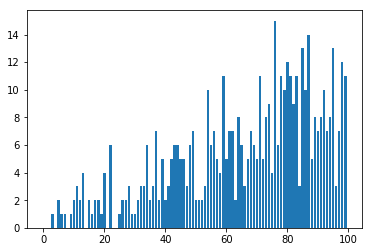

In [12]:
# Prioritize buffer sample 검증
counting = np.zeros(100)

td_sum = sum(td_buffer)
# td error를 이용해 확률분포 p를 구한다
p = [td_error / td_sum for td_error in td_buffer]

for _ in range(100):
    idxs = np.random.choice(np.arange(len(buffer)), batch_size, p=p)
    for idx in idxs:
        counting[idx] += 1

plt.bar(range(100), counting)

[200.0, 201.0, 202.0, 203.0, 204.0, 205.0, 206.0, 207.0, 208.0, 209.0, 210.0, 211.0, 212.0, 213.0, 214.0, 215.0, 216.0, 217.0, 218.0, 219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 225.0, 226.0, 227.0, 228.0, 229.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0]


<BarContainer object of 100 artists>

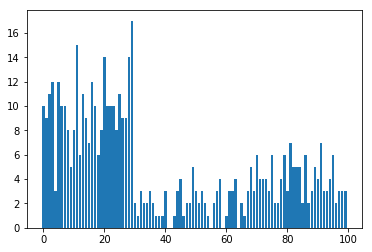

In [15]:
# Prioritize buffer update 검증
for i in range(30):
    td_buffer[i] = float(i + 200)
    
print(td_buffer)

td_sum = sum(td_buffer)
# td error를 이용해 확률분포 p를 구한다
p = [td_error / td_sum for td_error in td_buffer]
    
counting = np.zeros(100)
for _ in range(100):
    idxs = np.random.choice(np.arange(len(buffer)), batch_size, p=p)
    for idx in idxs:
        counting[idx] += 1

plt.bar(range(100), counting)

### PER 검증

<BarContainer object of 100 artists>

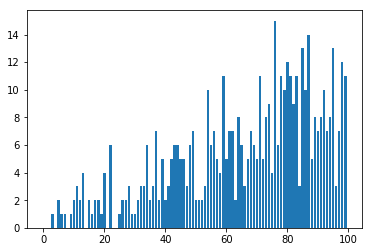

In [12]:
# buffer 생성
buffer = []
td_buffer = []

for i in range(100):
    buffer.append(transition)
    td_buffer.append(float(i))
print(len(buffer))
print("prior", td_buffer)

# Prioritize buffer sample 검증
counting = np.zeros(100)

td_sum = sum(td_buffer)
# td error를 이용해 확률분포 p를 구한다
p = [td_error / td_sum for td_error in td_buffer]

for _ in range(100):
    idxs = np.random.choice(np.arange(len(buffer)), batch_size, p=p)
    for idx in idxs:
        counting[idx] += 1

plt.bar(range(100), counting)

[200.0, 201.0, 202.0, 203.0, 204.0, 205.0, 206.0, 207.0, 208.0, 209.0, 210.0, 211.0, 212.0, 213.0, 214.0, 215.0, 216.0, 217.0, 218.0, 219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 225.0, 226.0, 227.0, 228.0, 229.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0]


<BarContainer object of 100 artists>

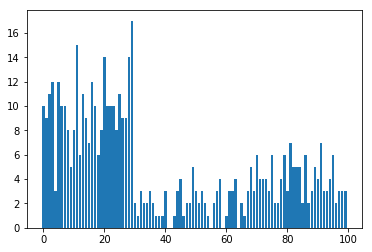

In [15]:
# Prioritize buffer update 검증
for i in range(30):
    td_buffer[i] = float(i + 200)
    
print(td_buffer)

td_sum = sum(td_buffer)
# td error를 이용해 확률분포 p를 구한다
p = [td_error / td_sum for td_error in td_buffer]
    
counting = np.zeros(100)
for _ in range(100):
    idxs = np.random.choice(np.arange(len(buffer)), batch_size, p=p)
    for idx in idxs:
        counting[idx] += 1

plt.bar(range(100), counting)

### Prioritized Replay Buffer class

In [8]:
class PrioritizedReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = []
        self.prior_buffer = []
        self.capacity = capacity
        self.idx = 0
        self.max_priority = 1.0
        
        self.alpha = 0.6

    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        transition = (state, action, reward, next_state, done)
        
        if len(self.buffer) == self.capacity:
            self.buffer[self.idx] = transition
            self.prior_buffer[self.idx] = self.max_priority ** self.alpha
            self.idx = (self.idx + 1) % self.capacity
            
        else:
            self.buffer.append(transition)
            self.prior_buffer.append(self.max_priority ** self.alpha)
        
    def sample(self, batch_size, beta=0.4):
        # priror 계산 후 우선순위에 대한 확률에 따라 sample
        td_sum = sum(self.prior_buffer)
        p = [td_error / td_sum for td_error in self.prior_buffer]
        idxs = np.random.choice(np.arange(len(self.buffer)), batch_size, p=p)

        state, action, reward, next_state, done = [], [], [], [], []
        for i in idxs:
            s, a, r, n_s, d = self.buffer[i]
            state.append(np.array(s, copy=False))
            action.append(np.array(a, copy=False))
            reward.append(np.array(r, copy=False))
            next_state.append(np.array(n_s, copy=False))
            done.append(np.array(d, copy=False))
        
        # importance sampling weights 계산
        weights = [(len(self.buffer) * p[idx]) ** (-beta) for idx in idxs]
        weights /= np.max(weights)
        weights = np.array(weights)

        state = np.array(state)
        action = np.array(action)
        reward = np.array(reward)
        next_state = np.array(next_state)
        done = np.array(done)
        
        return state, action, reward, next_state, done, idxs, weights
    
    def update_priority(self, idxs, priorities):
        for idx, prior in zip(idxs, priorities):
            self.prior_buffer[idx] = prior ** self.alpha
            
            self.max_priority = max(self.max_priority, prior)

### DQN Agent Class
<img src="./img/hyperparameters.png" width="100%" align="left"> 

In [9]:
layer = tf.contrib.layers

class DQNAgent:
    def __init__(self, sess, state_size, action_size):
        self.sess = sess

        self.state_size = state_size
        self.action_size = action_size

        # hyper parameter
        self.batch_size = 32
        self.discount_factor = 0.99
        self.learning_rate = 0.00025

        # epsilon
        self.s_epsilon = 1.0
        self.e_epsilon = 0.01
        self.n_epsilon_decay = 1000
        self.epsilon = self.s_epsilon

        # place holder
        self.input_policy = tf.placeholder(tf.float32, shape=(None, self.state_size))
        self.input_target = tf.placeholder(tf.float32, shape=(None, self.state_size))
        
        self.actions = tf.placeholder(tf.int32, shape=None)
        self.targets = tf.placeholder(tf.float32, shape=None)
        
        self.weights = tf.placeholder(tf.float32, shape=None)

        # network
        self.policy_q = self._build_network(self.input_policy, net_name="policy_net")
        self.target_q = self._build_network(self.input_target, net_name="target_net")
        self.sess.run(tf.global_variables_initializer())
        self.update_target_network()

        # replay buffer
        self.buffer = PrioritizedReplayBuffer(1000)

        # optimizer
        self.loss_op, self.train_op, self.td_error_op = self._build_op()
        
    def _build_network(self, inputs, net_name):
        with tf.variable_scope(net_name):
            fc1 = layer.fully_connected(
                inputs=inputs,
                num_outputs=128,
                activation_fn=tf.nn.relu,
            )
            fc2 = layer.fully_connected(
                inputs=fc1,
                num_outputs=128,
                activation_fn=tf.nn.relu,
            )
            q_value = layer.fully_connected(
                inputs=fc2,
                num_outputs=self.action_size,
                activation_fn=None,
            )
            return q_value

    def _build_op(self):
        """신경망 학습을 위한 Loss function과 Optimaizer를 정의합니다."""
        action_one_hot = tf.one_hot(self.actions, self.action_size, 1.0, 0.0)
        predict_q = tf.reduce_sum(tf.multiply(self.policy_q, action_one_hot), axis=1)
        
        td_error_op = tf.square(self.targets - predict_q) * self.weights
        loss_op = tf.reduce_mean(td_error_op)
        train_op = tf.train.RMSPropOptimizer(
            learning_rate=self.learning_rate,
            decay=0.95,
            momentum=0.95,
            epsilon=0.01
        ).minimize(loss_op)
        return loss_op, train_op, td_error_op

    def select_action(self, state):
        """epsilon-greedy로 action을 선택합니다."""
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = np.random.randint(self.action_size)
        else:
            state = np.expand_dims(state, axis=0)
            selected_action = self.sess.run(
                self.policy_q,
                feed_dict={self.input_policy: state}
            )
            selected_action = np.argmax(selected_action, axis=1)
            selected_action = selected_action[0]

        # 매 step마다 epsilon을 줄여나갑니다.
        if self.epsilon >= self.e_epsilon:
            self.epsilon -= (self.s_epsilon - self.e_epsilon) / self.n_epsilon_decay
        return selected_action

    def update_model(self):
        """학습 네트워크를 학습합니다."""
        states, actions, rewards, next_states, dones, idxs, weights = self.buffer.sample(self.batch_size)

        target_q = self.target_q.eval({self.input_target: next_states}, self.sess)
        target_q = np.max(target_q, axis=1)
        targets = rewards + self.discount_factor * target_q * (1. - dones)

        loss, td_error, _ = self.sess.run(
            [self.loss_op, self.td_error_op, self.train_op],
            feed_dict={self.input_policy: states,
                       self.actions: actions,
                       self.targets: targets,
                       self.weights: weights})
        
        priorities = td_error + 1e-6
        self.buffer.update_priority(idxs, priorities)

        return loss

    def update_target_network(self):
        """학습 네트웍의 변수의 값들을 타겟 네트웍으로 복사해서 타겟 네트웍의 값들을 최신으로 업데이트합니다."""
        copy_op = []

        main_q_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="policy_net")
        target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="target_net")

        for main_q_var, target_var in zip(main_q_vars, target_vars):
            copy_op.append(target_var.assign(main_q_var.value()))
        self.sess.run(copy_op)

### DQN agent train

In [10]:
# Session 열기
tf.reset_default_graph()
sess = tf.Session()

# DQN Agent 객체 생성
agent = DQNAgent(sess, state_size, action_size)

# 변수 초기화
sess.run(tf.global_variables_initializer())

### DQN 학습

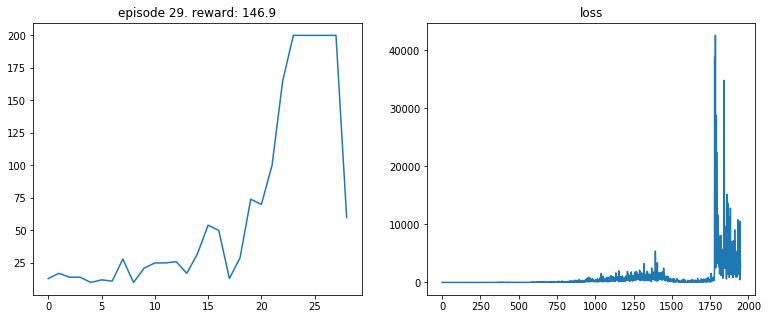

2091


In [11]:
EPISODE = 30

replay_initial = 50
target_update = 10

total_step = 1
all_episode_reward = []
losses = []

for e in range(EPISODE):
    print("EPISODE: {}".format(e+1))
    observation = env.reset()
    done = False
   
    step = 1
    episode_reward = 0
    frames = []
    
    while not done:
        
        # action 선택
        action = int(agent.select_action(observation))
        
        # 선택한 action으로 env.step()
        next_observation, reward, done, _ = env.step(action)
        step += 1
        total_step += 1
        episode_reward += reward
        
        # trajectory(S, A, R, S', done)를 Replay buffer에 저장 
        agent.buffer.add(observation, action, reward, next_observation, done)
        observation = next_observation
        
        # 만약에 episode가 끝났으면 reward 저장
        if done:
            all_episode_reward.append(episode_reward)
        
        # replay buffer가 일정 이상 채워지면 학습 시작
        if len(agent.buffer) > replay_initial:
            loss = agent.update_model()
            losses.append(loss)
            
        # 일정 step마다 target Q 업데이트
        if total_step > replay_initial and total_step % target_update == 0:
            agent.update_target_network()
            
        # 그래프 그리기
        if total_step % 100 == 0:
            plot(step, e, all_episode_reward, losses)
            
    print(total_step)
    env.close()

### 학습된 DQN 테스트

EPISODE: 1
step 201
reward 200.0



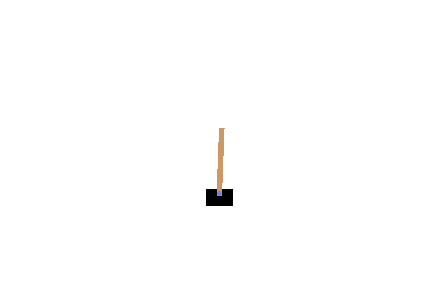
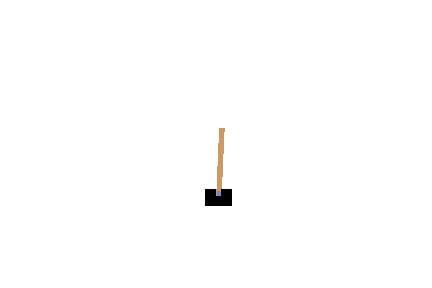
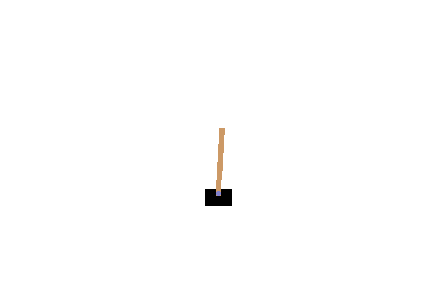
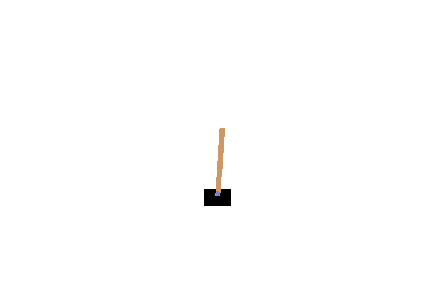
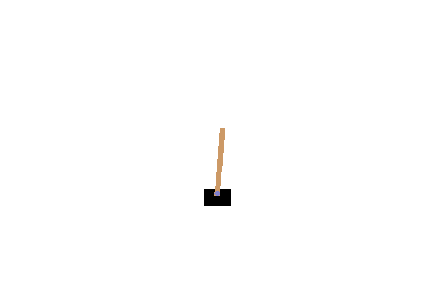
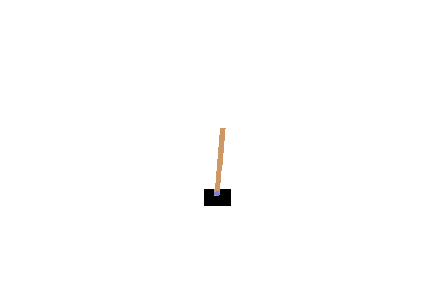
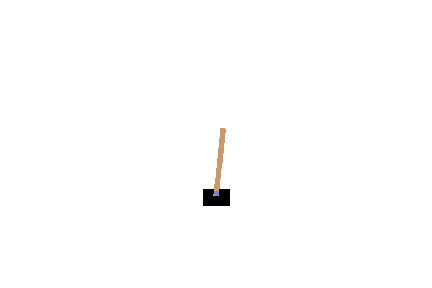
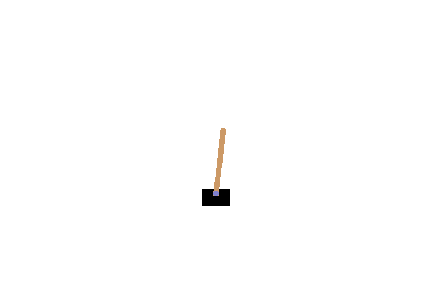
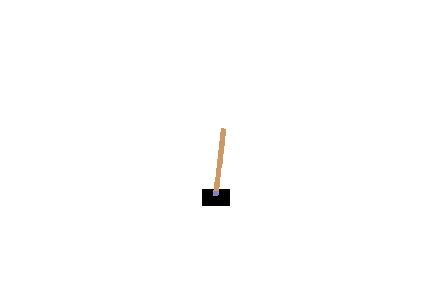
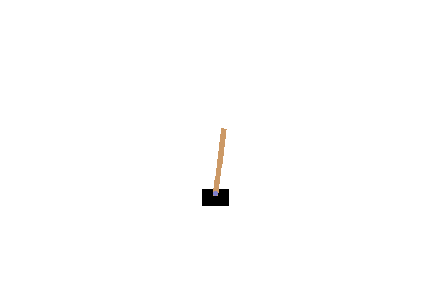
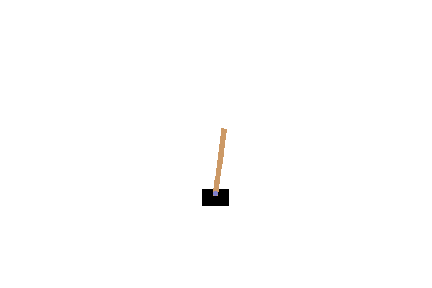
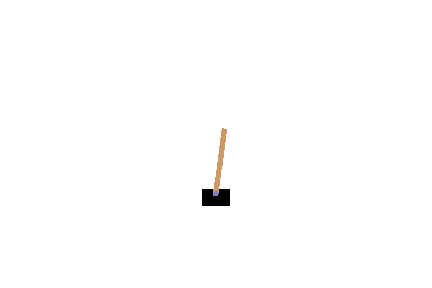
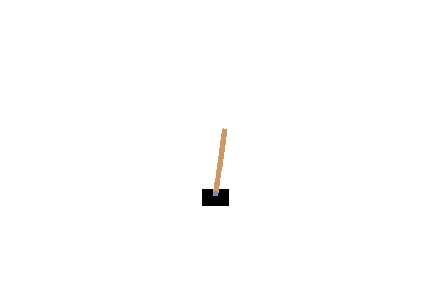
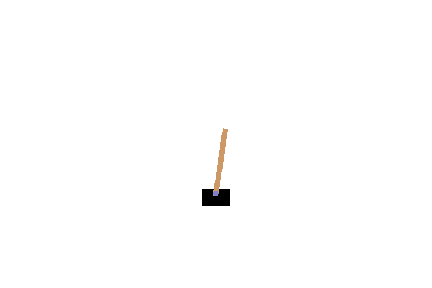
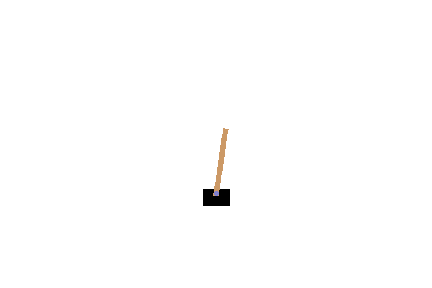
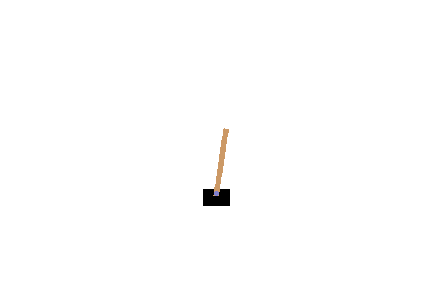
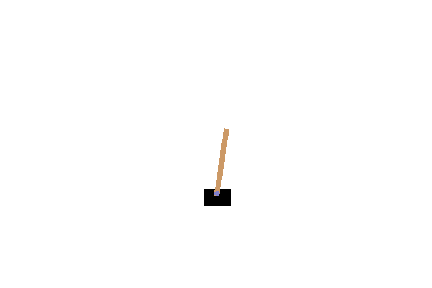
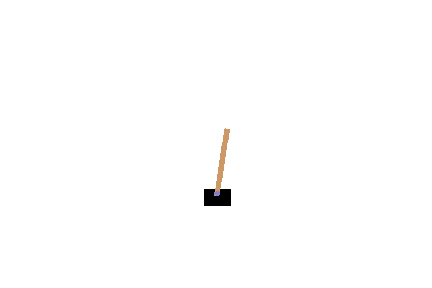
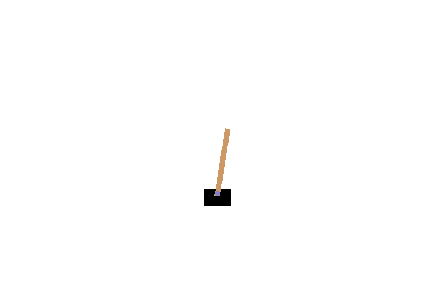
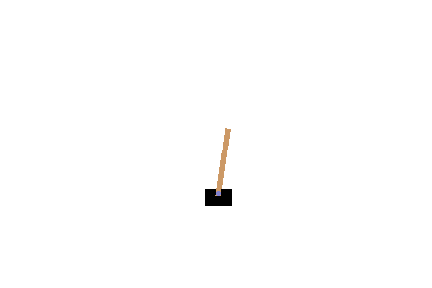
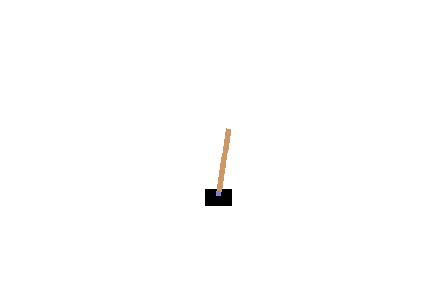
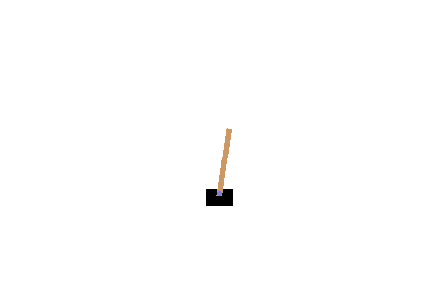
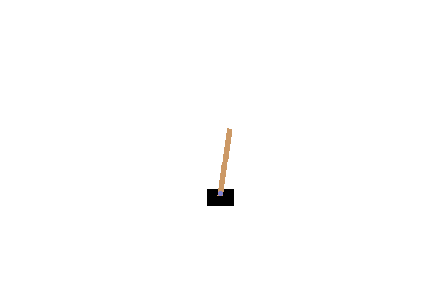
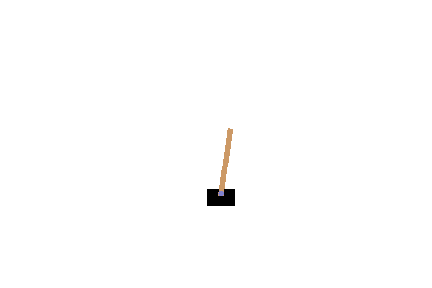
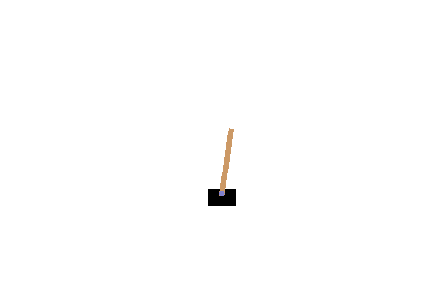
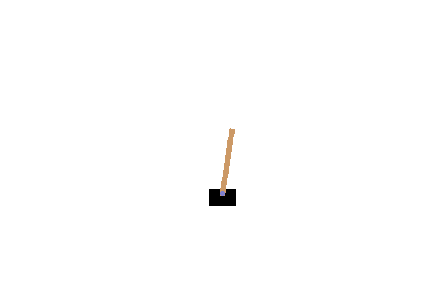
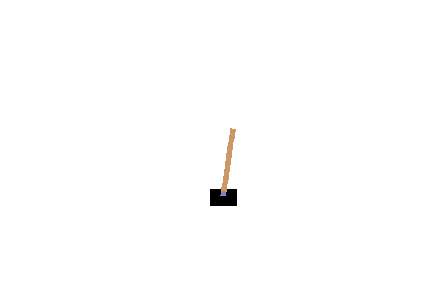
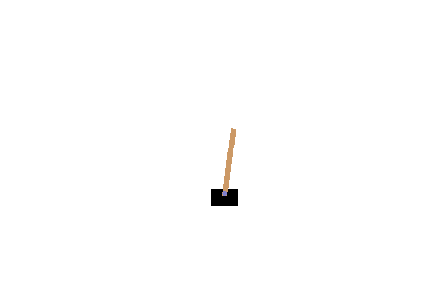
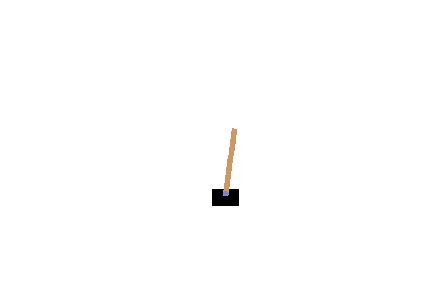
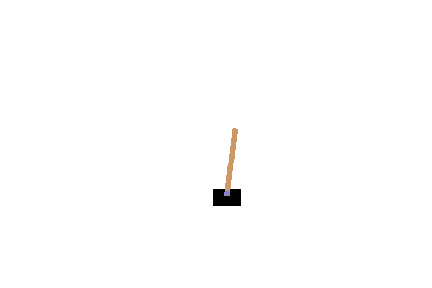
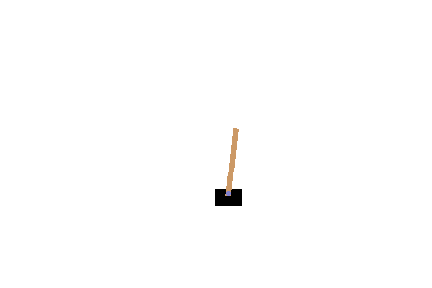
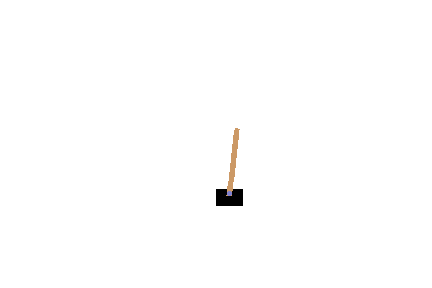
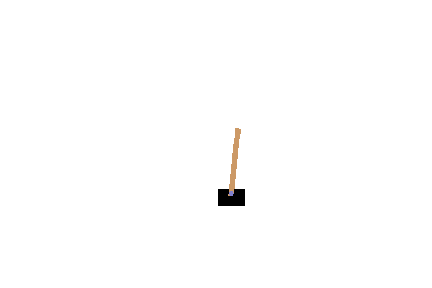
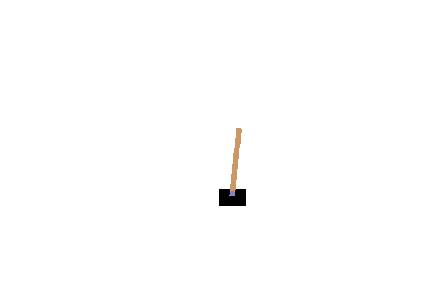
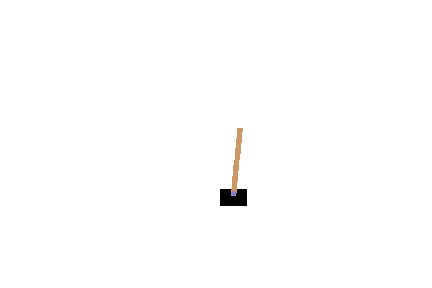
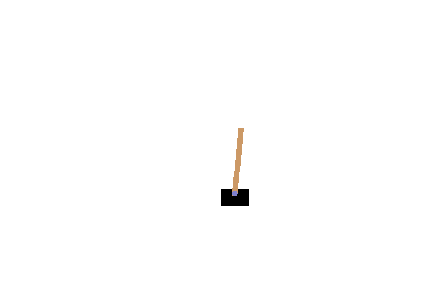
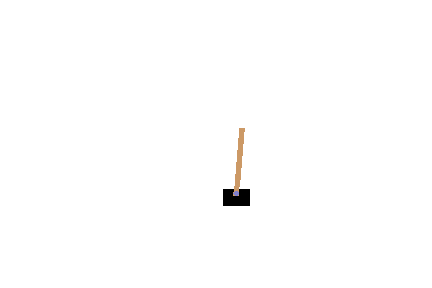
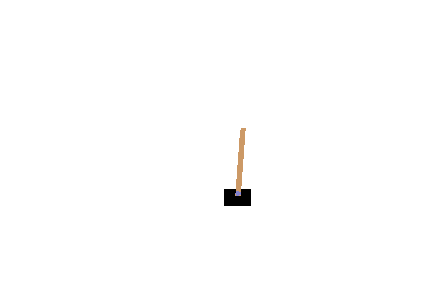
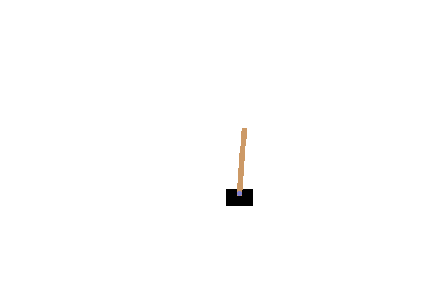
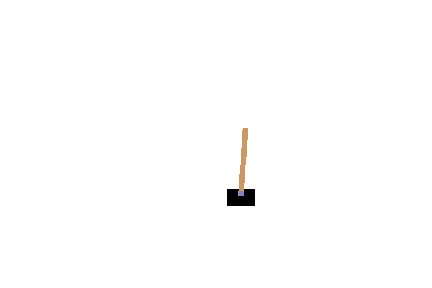
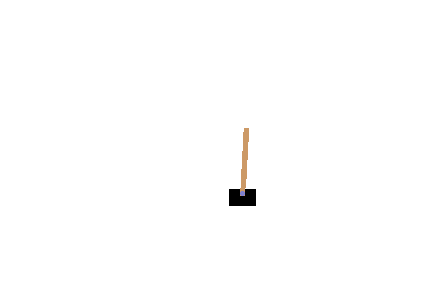
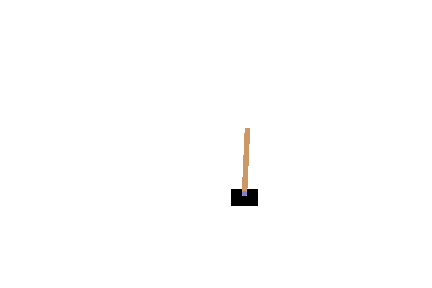
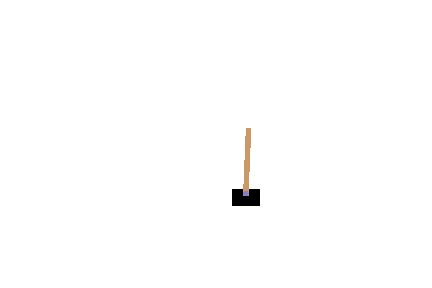
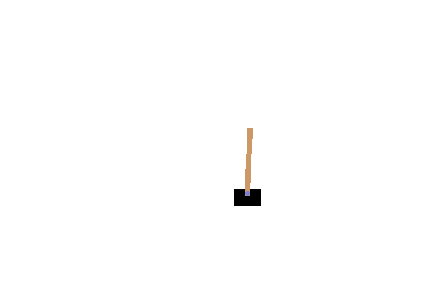
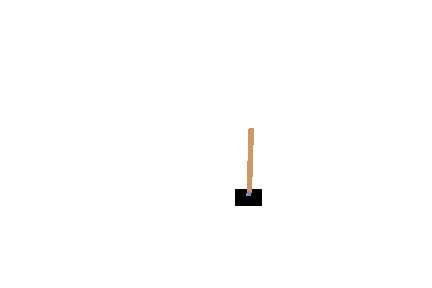
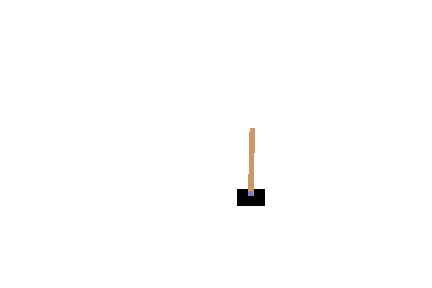
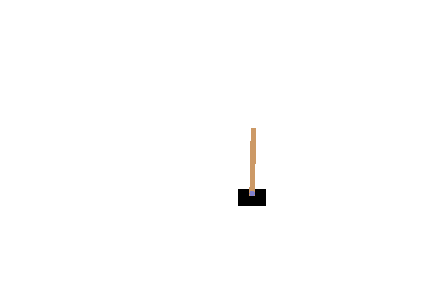
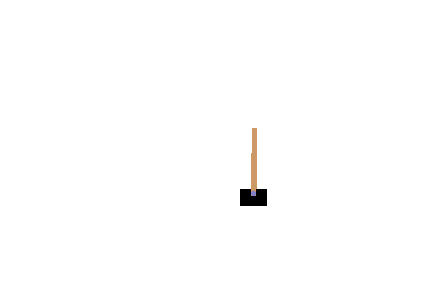
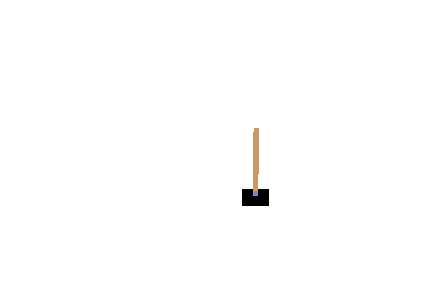
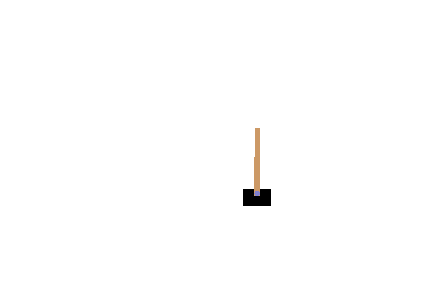
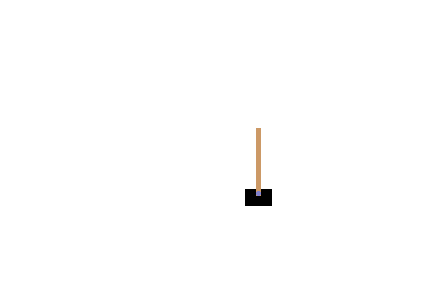
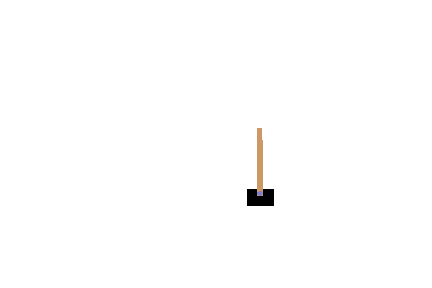
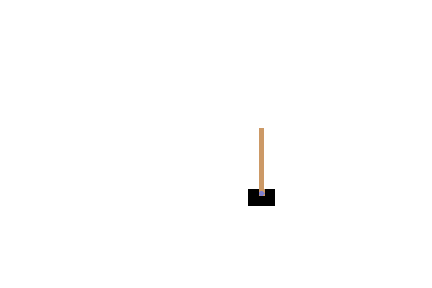
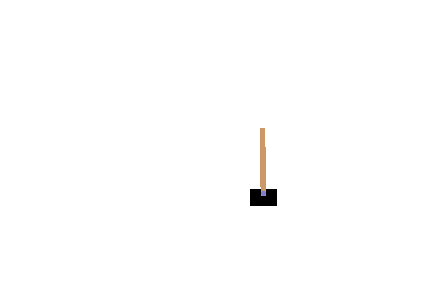
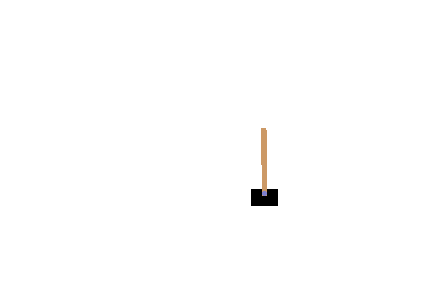
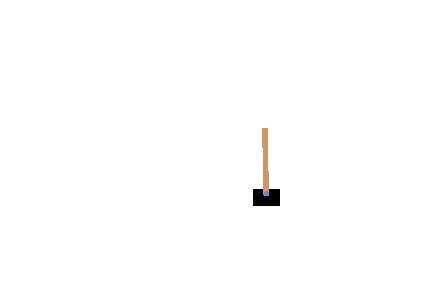
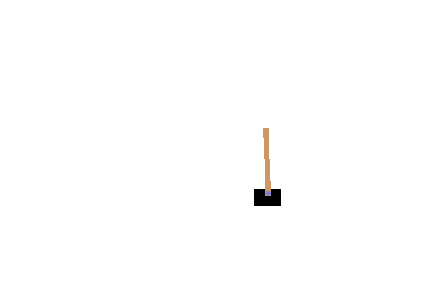
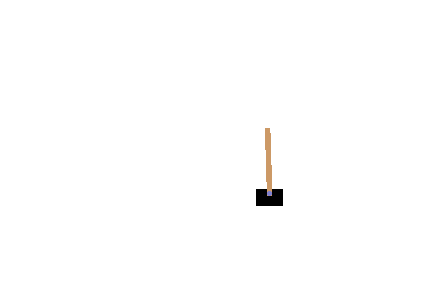
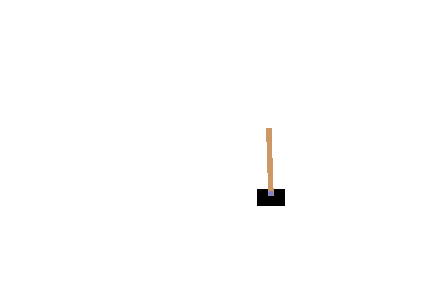
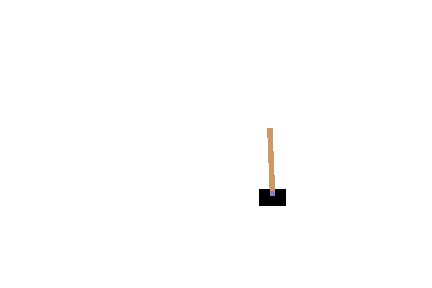
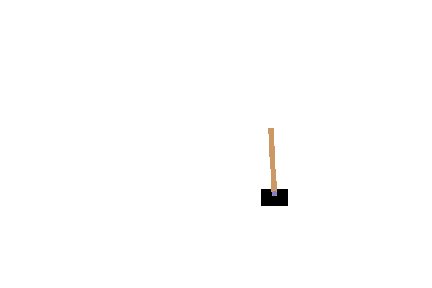
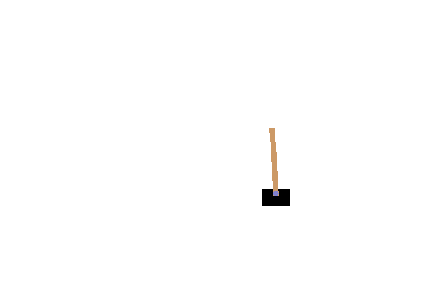
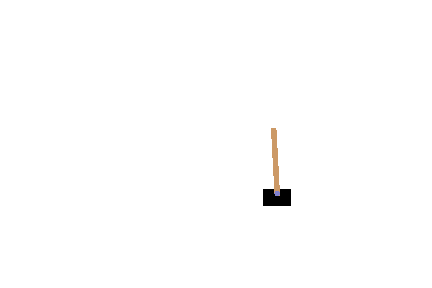
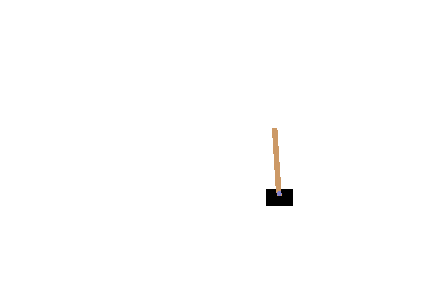
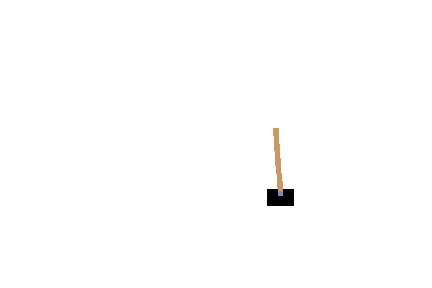
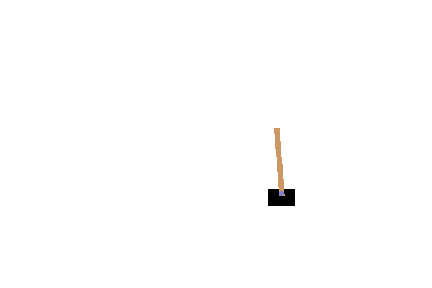
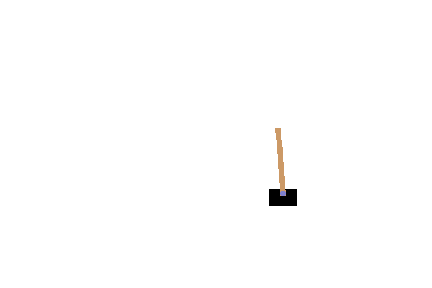
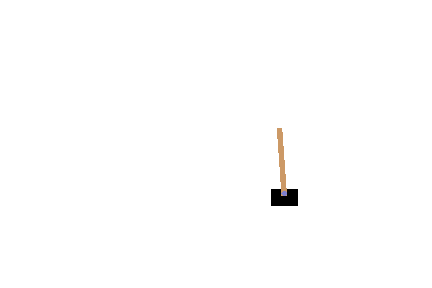
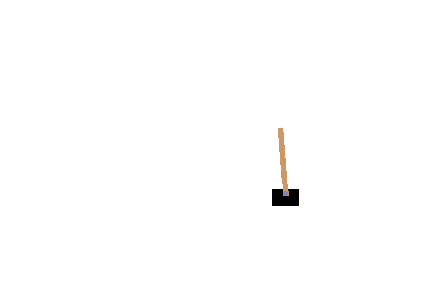
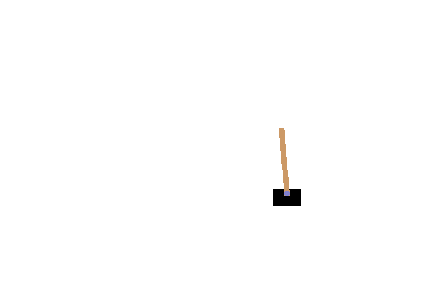
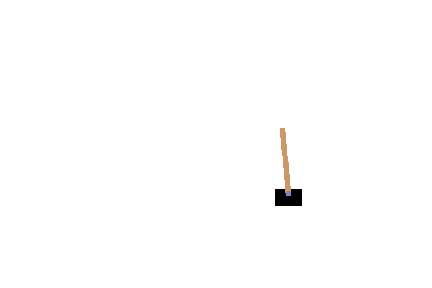
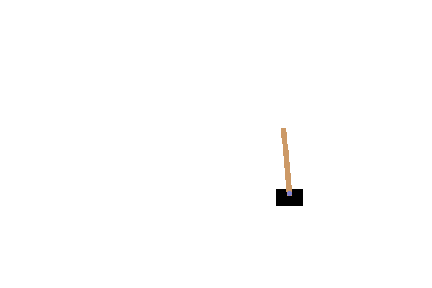
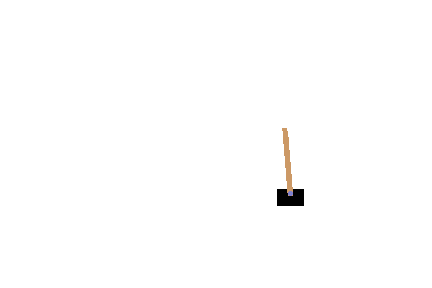
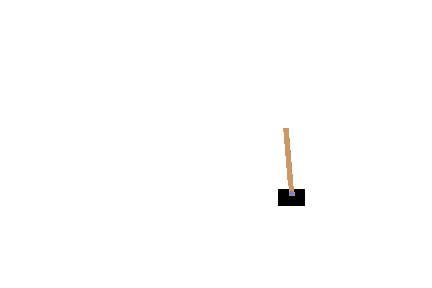
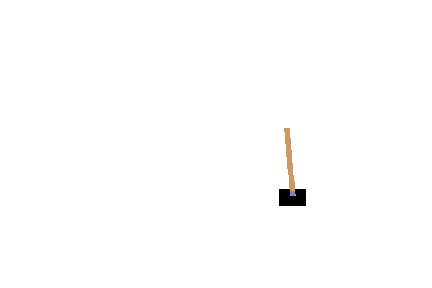
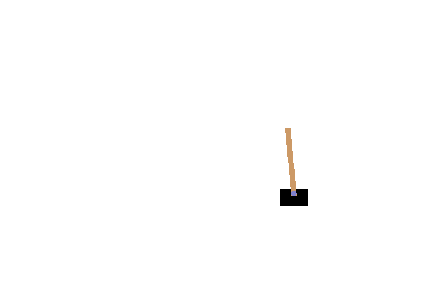
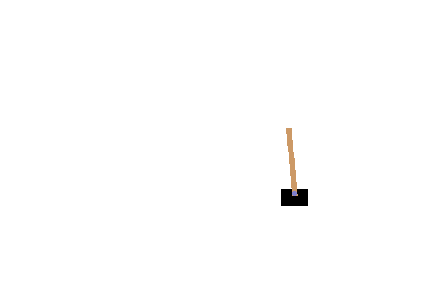
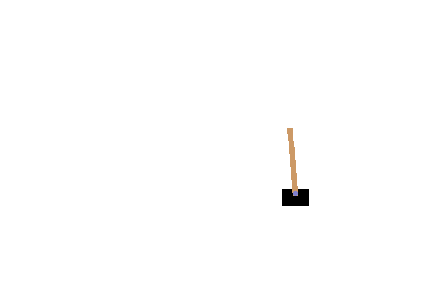
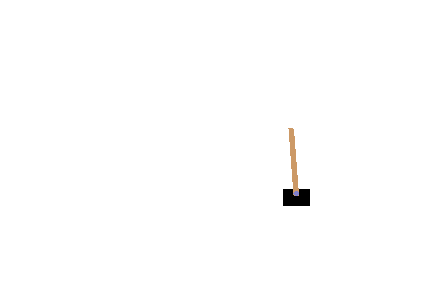
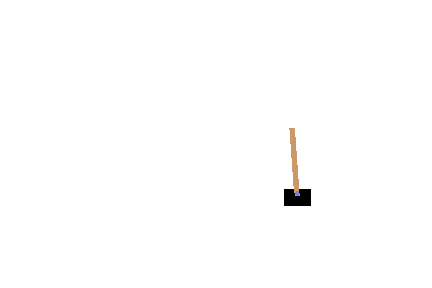
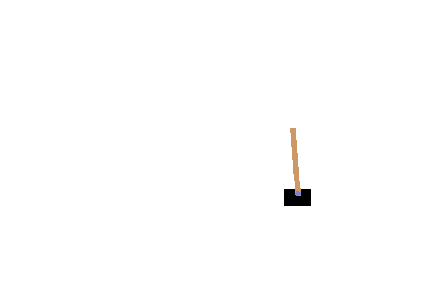
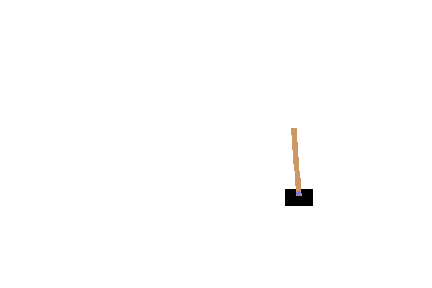
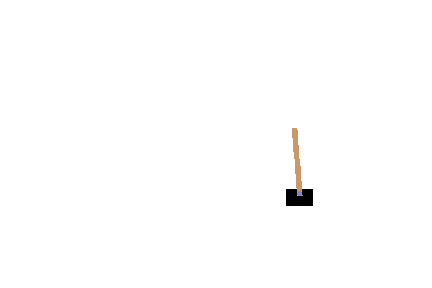
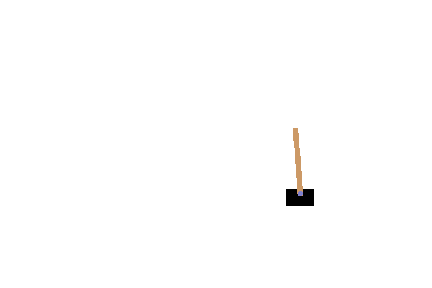
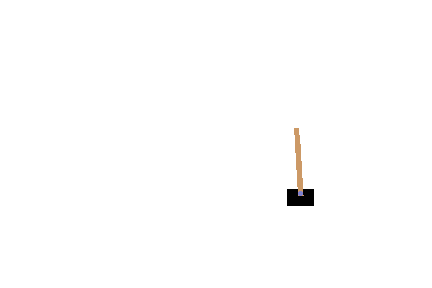
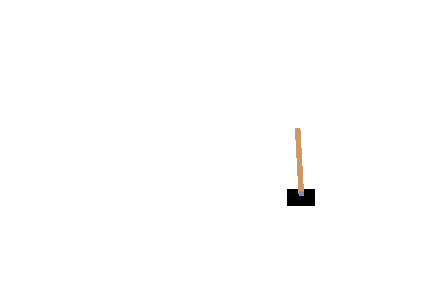
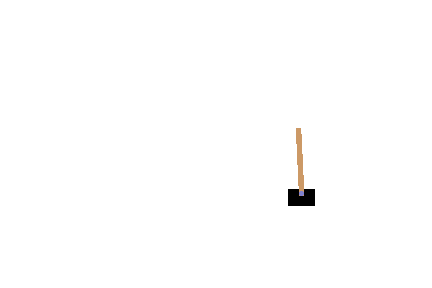
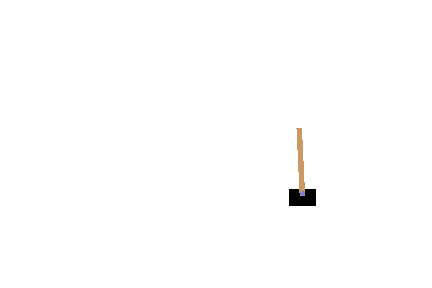
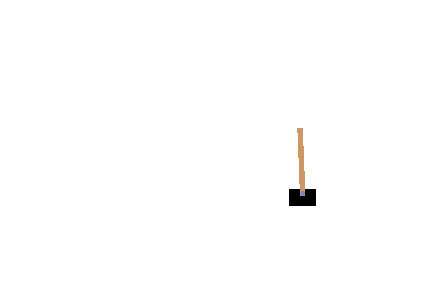
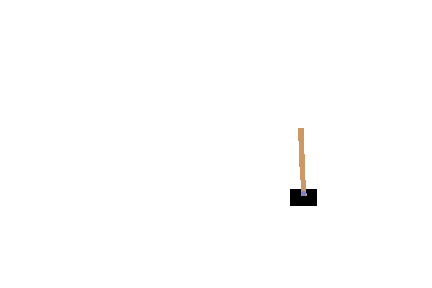
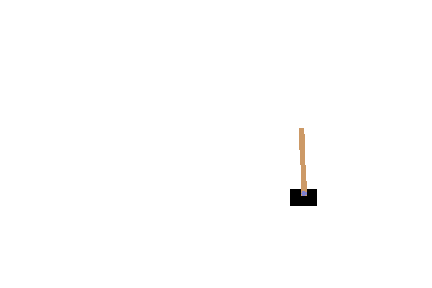
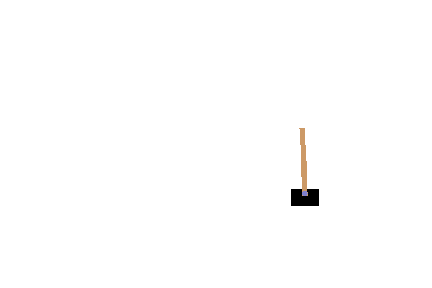
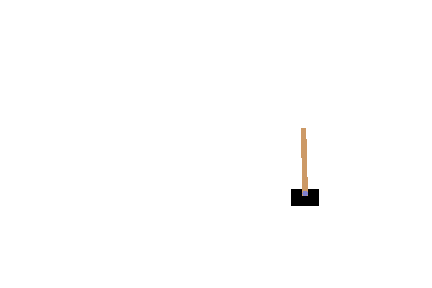
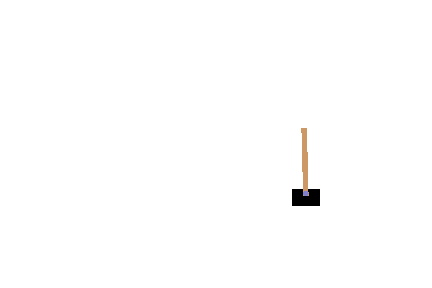
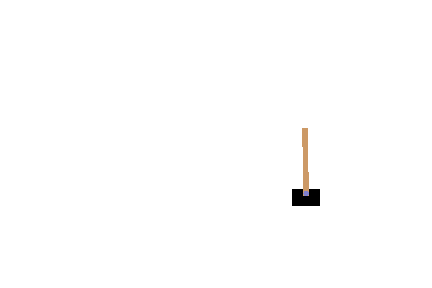
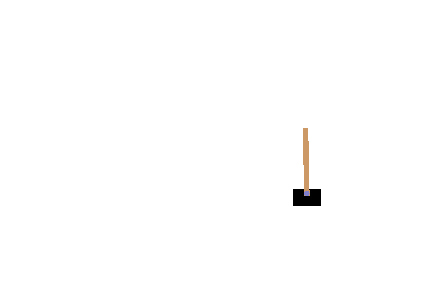
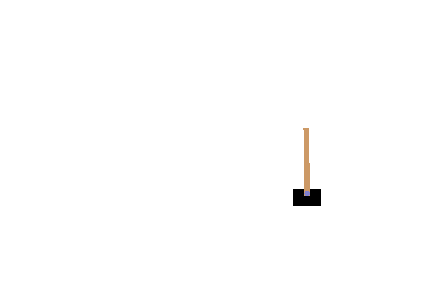
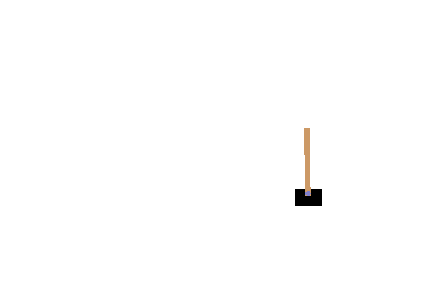
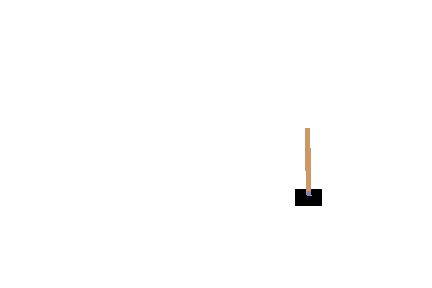
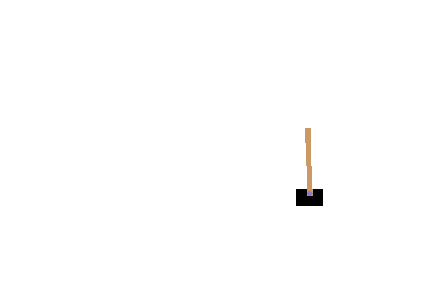
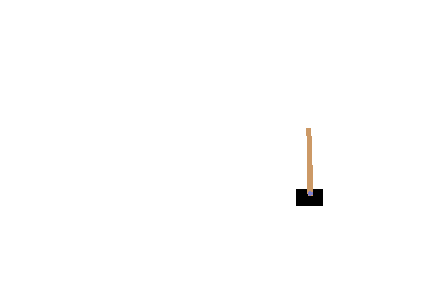
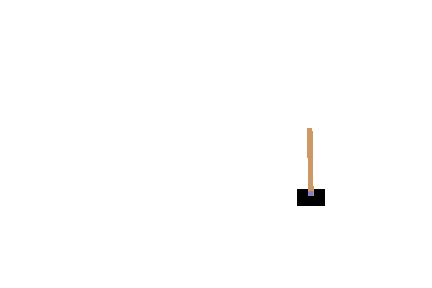
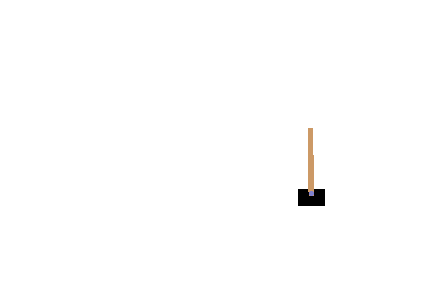
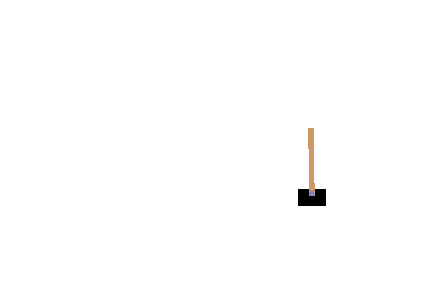
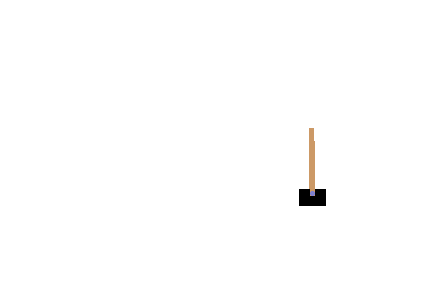
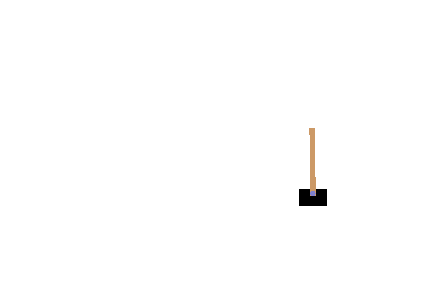
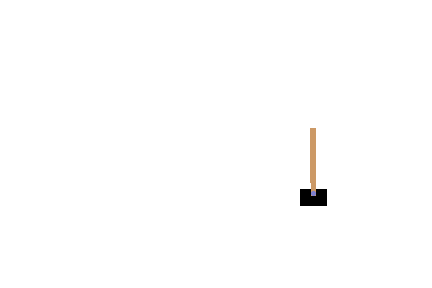
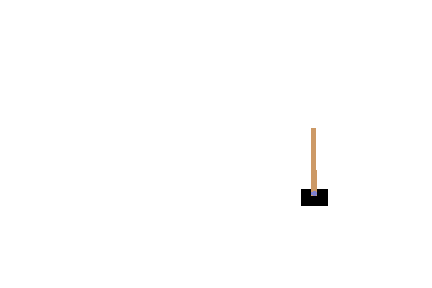
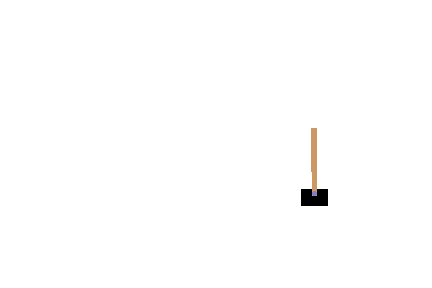
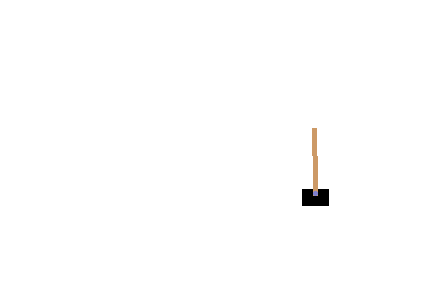
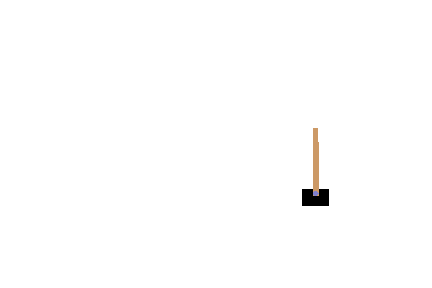
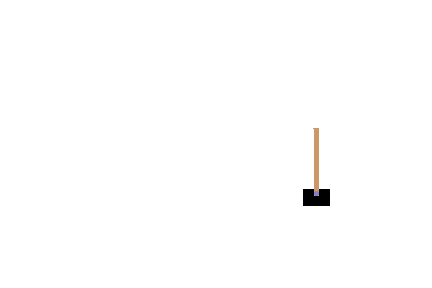
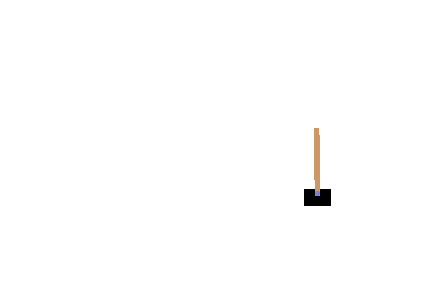
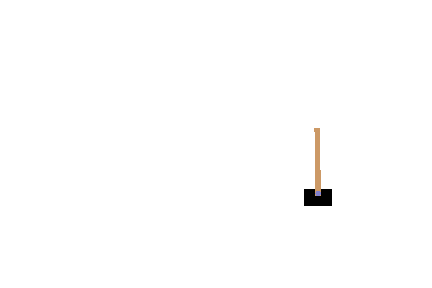
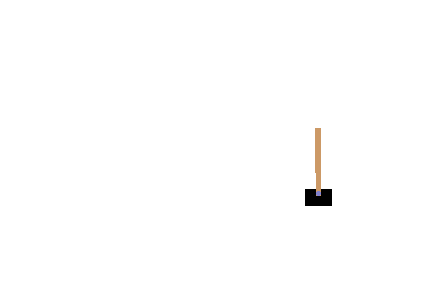
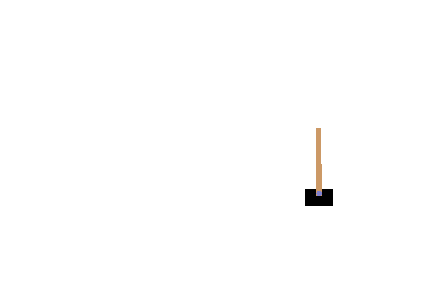
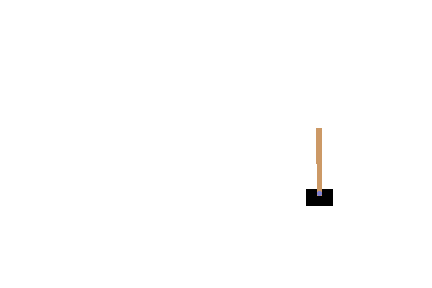
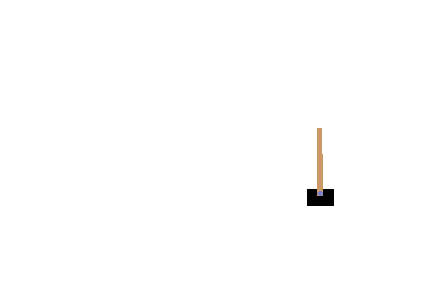
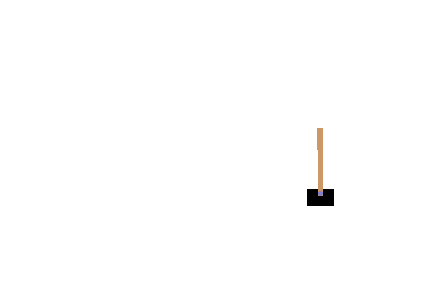
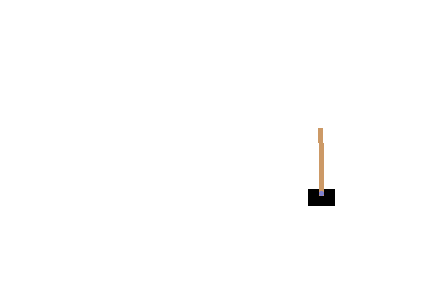
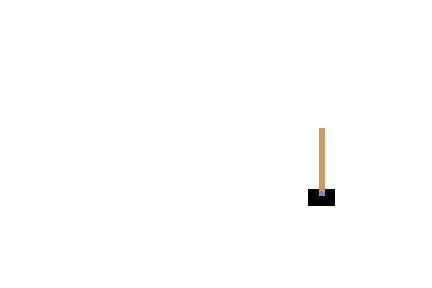
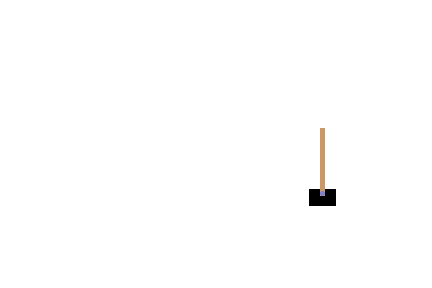
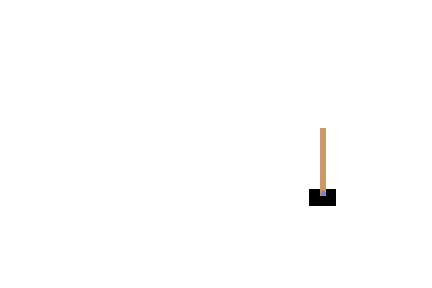
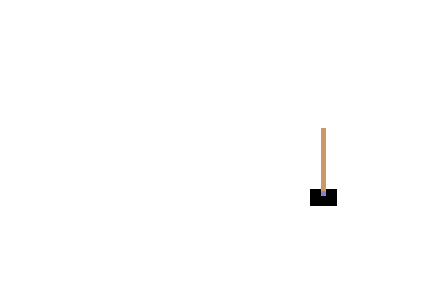
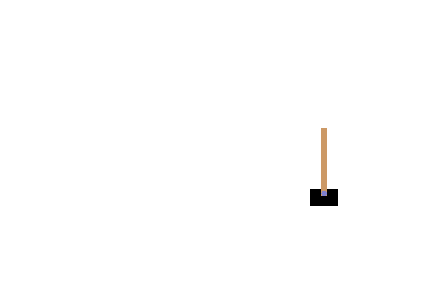
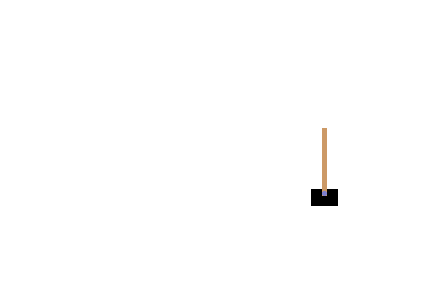
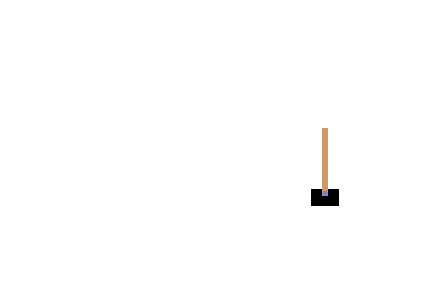
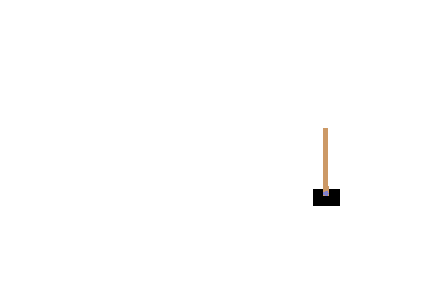
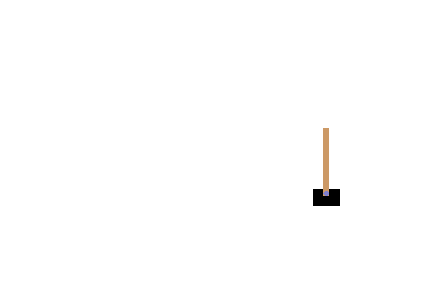
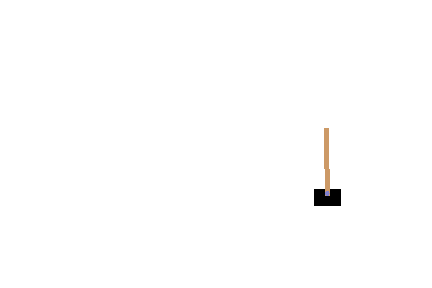
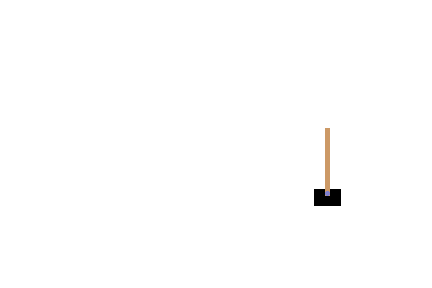
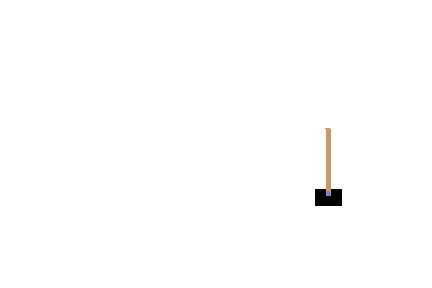
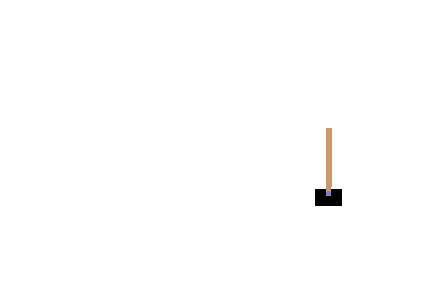
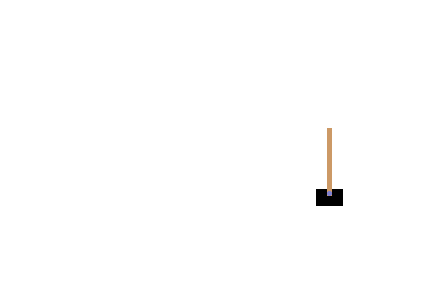
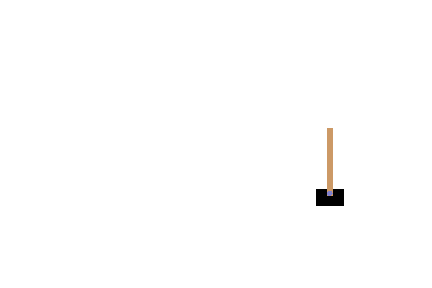
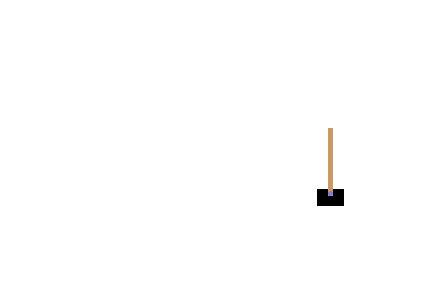
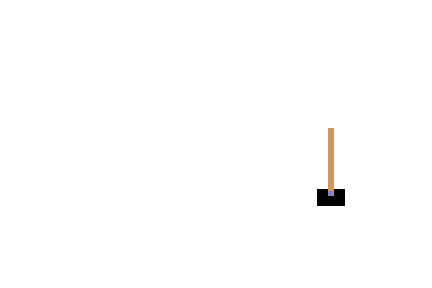
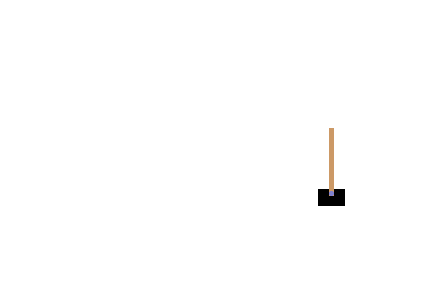
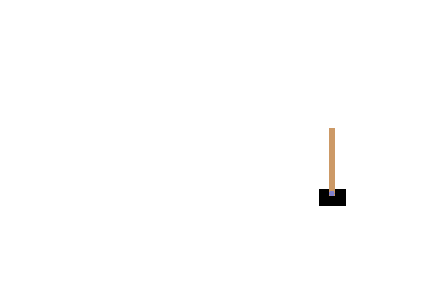
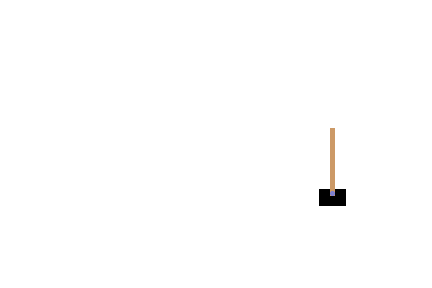
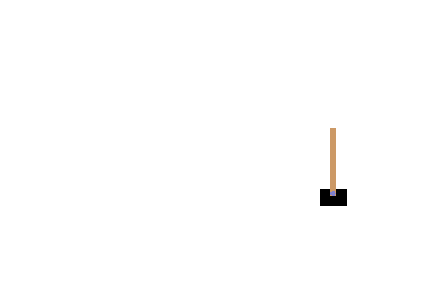
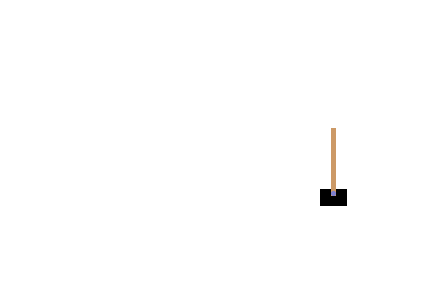
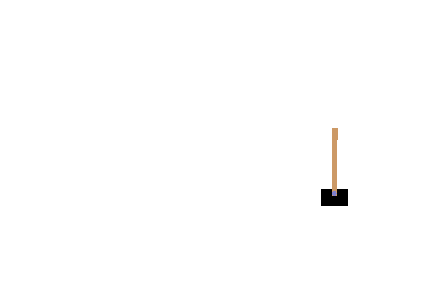
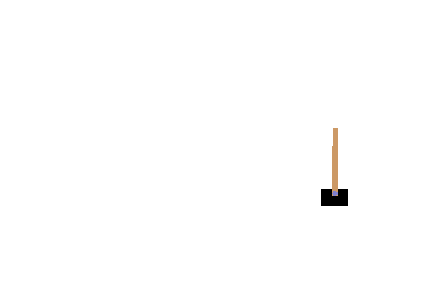
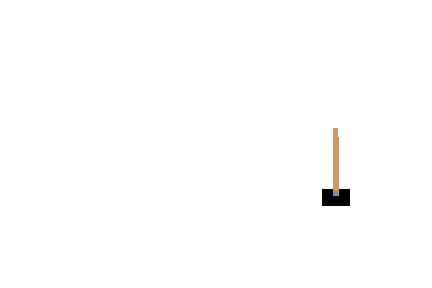
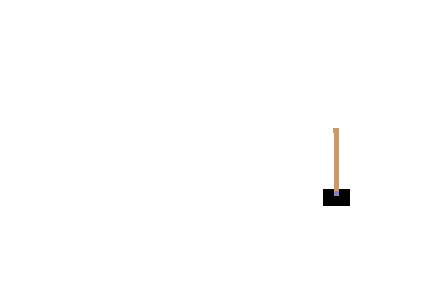
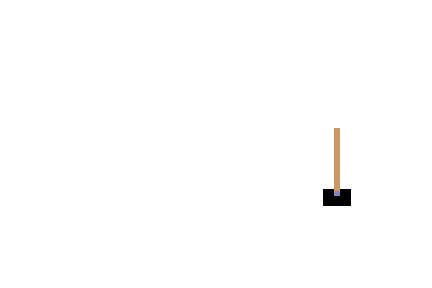
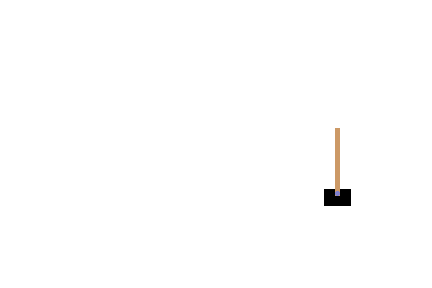
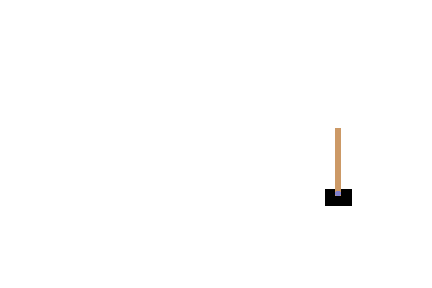
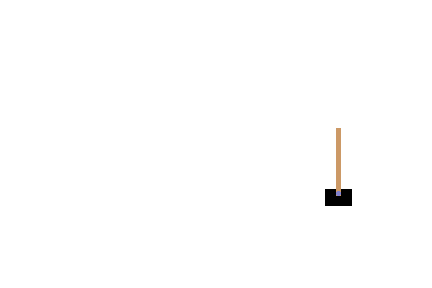
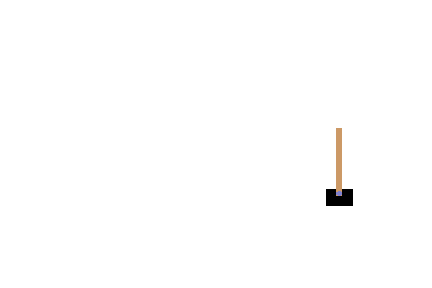
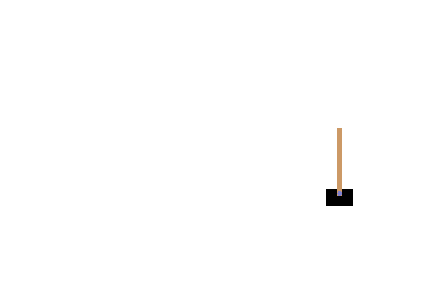
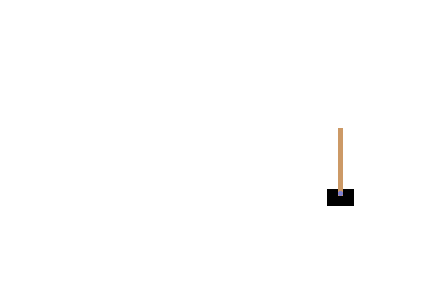
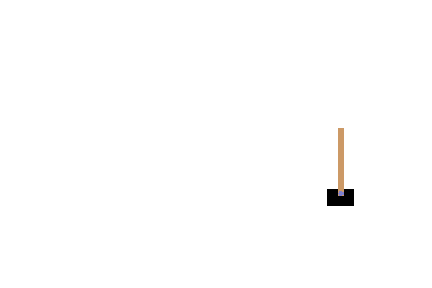
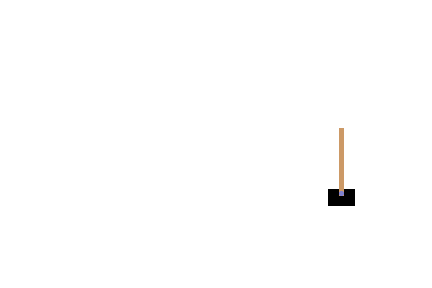
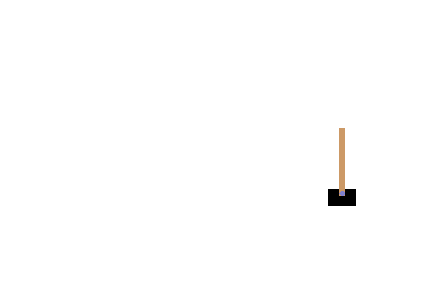
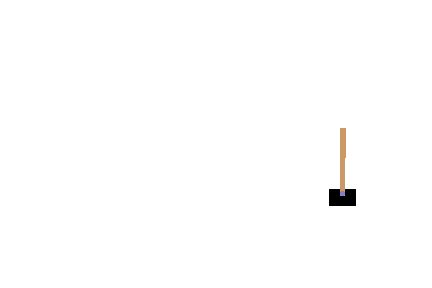
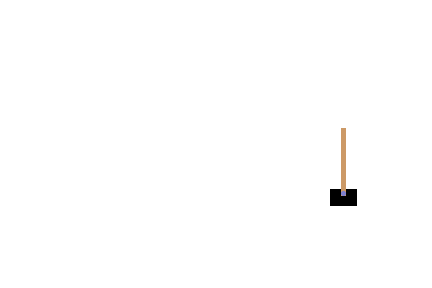
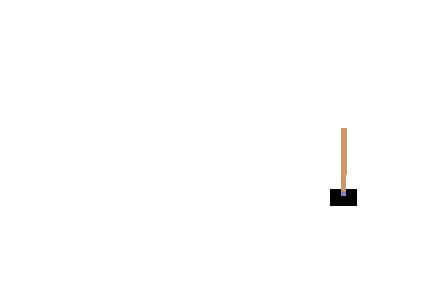
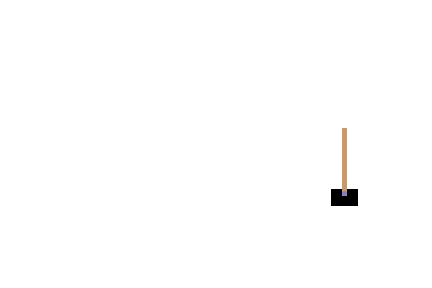
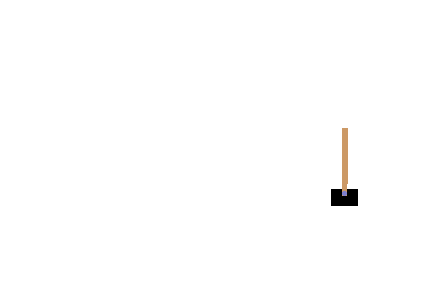
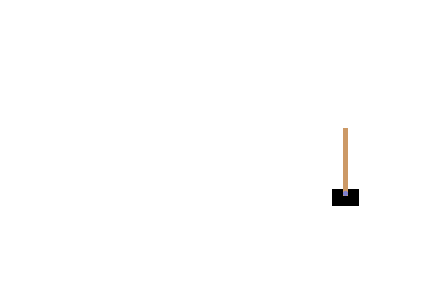
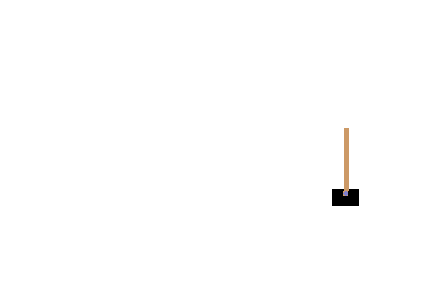
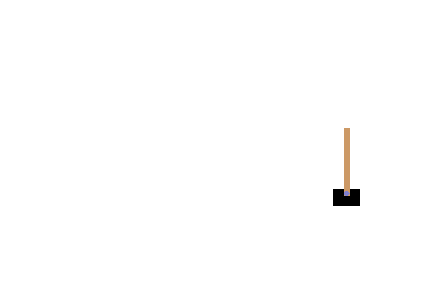
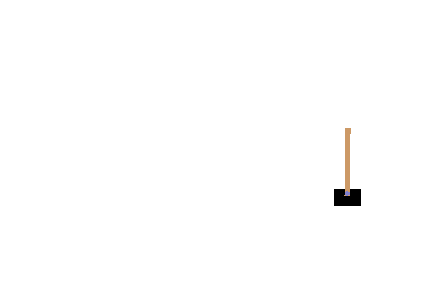
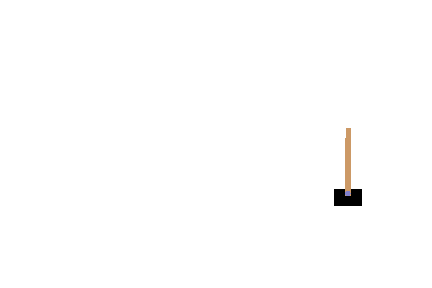
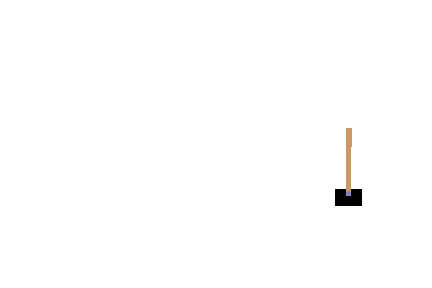
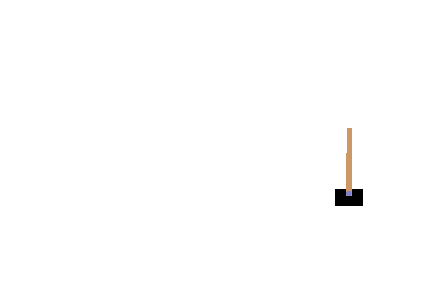
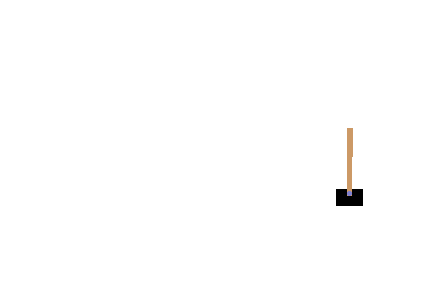
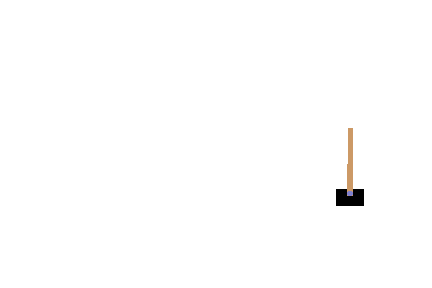
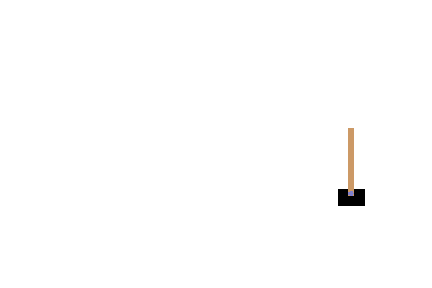
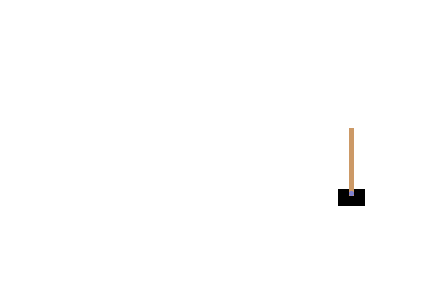
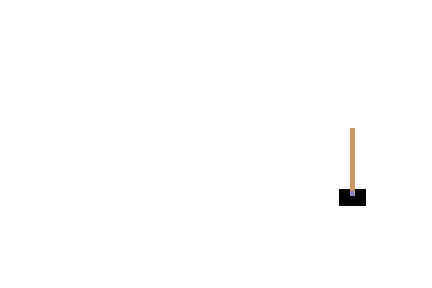
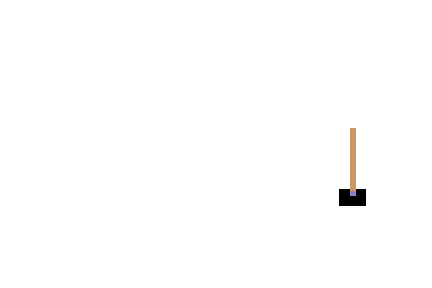
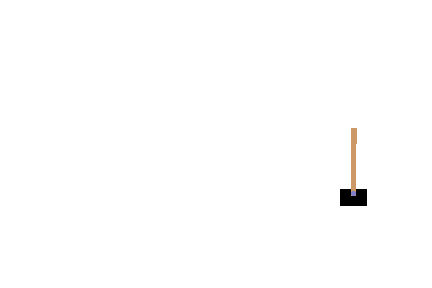
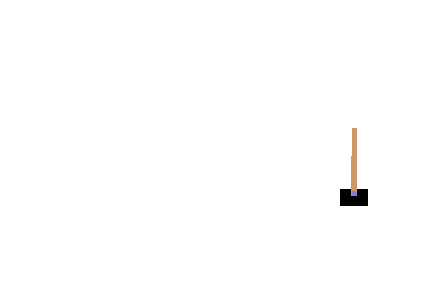
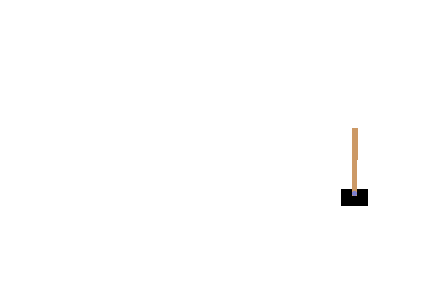
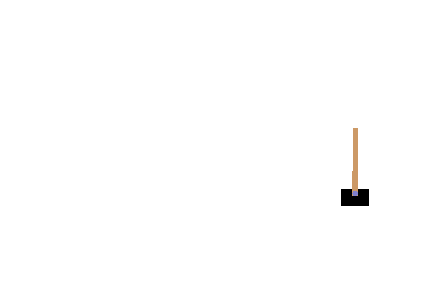
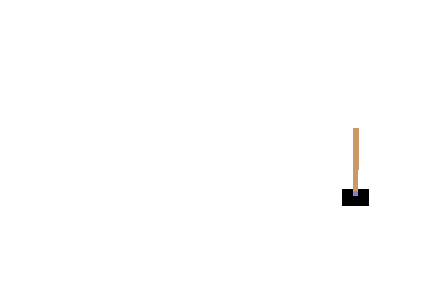
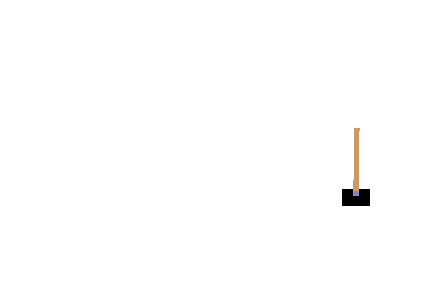
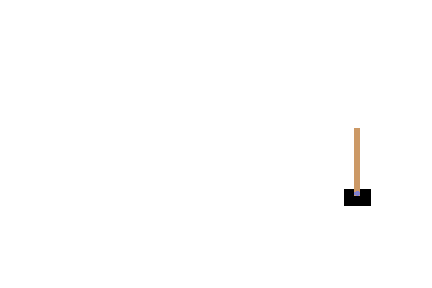
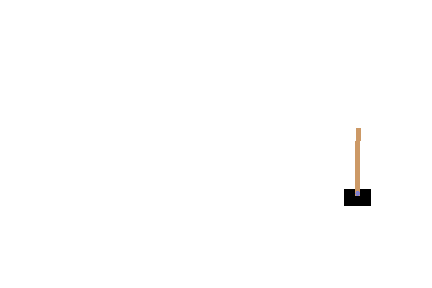
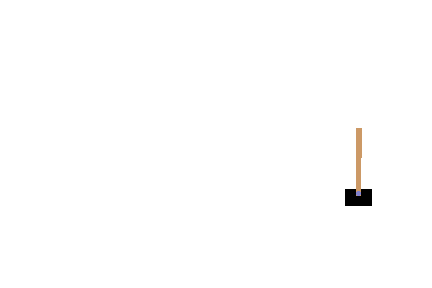
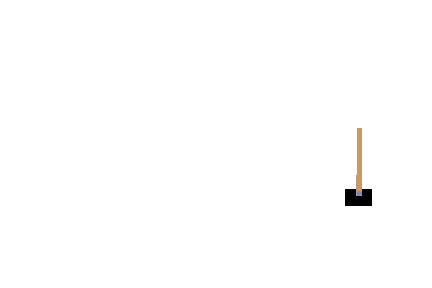
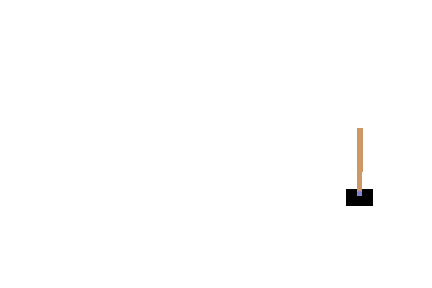
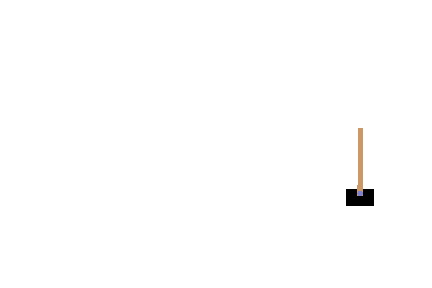
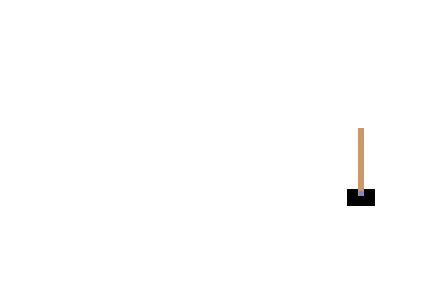
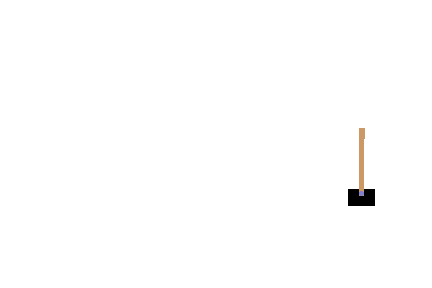
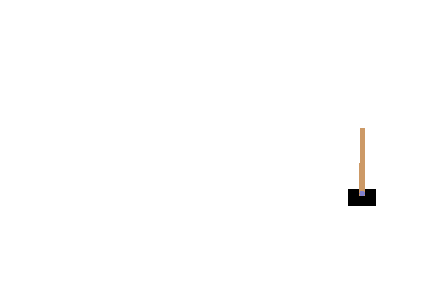
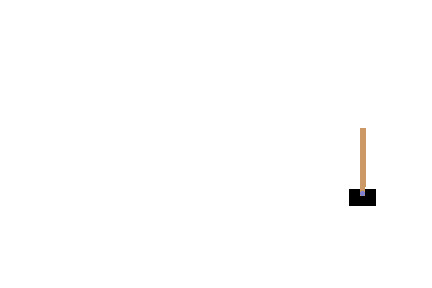
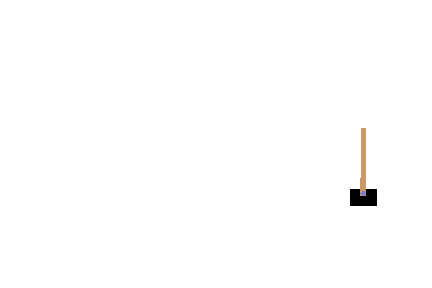
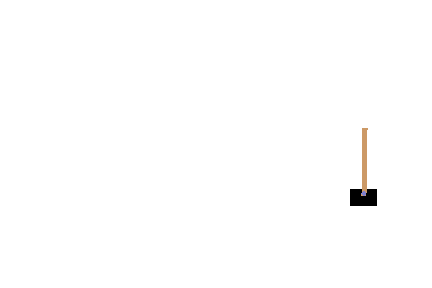
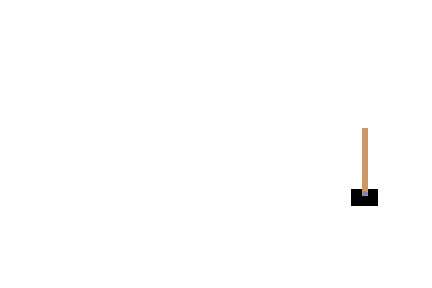
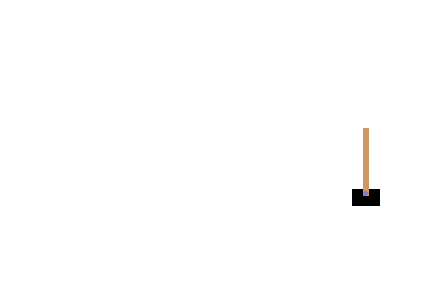
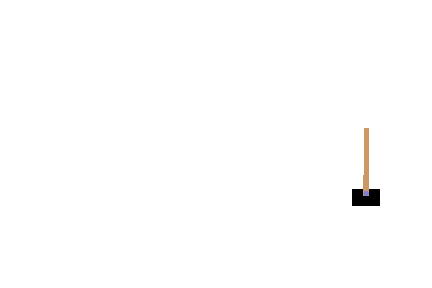
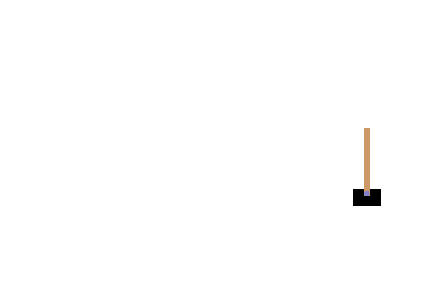
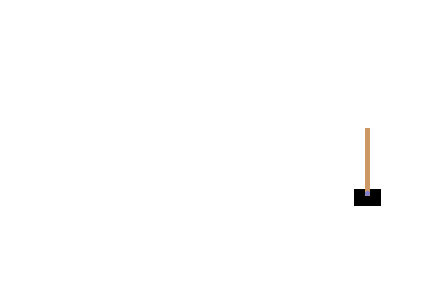
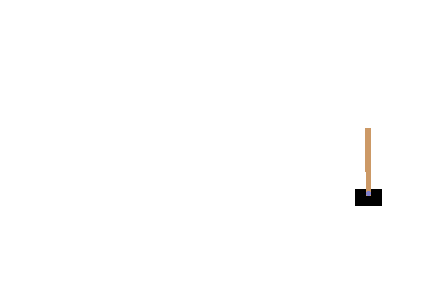
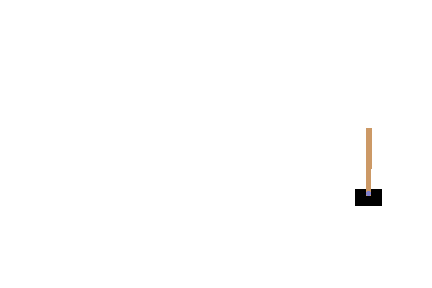
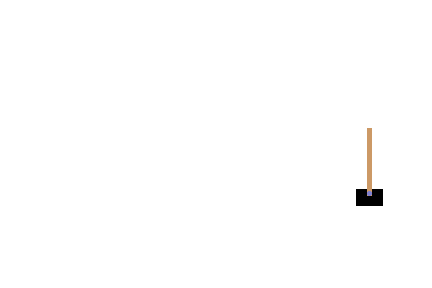

In [12]:
EPISODE = 1

all_episode_reward = []
losses = []

for e in range(EPISODE):
    print("EPISODE: {}".format(e+1))
    observation = env.reset()
    done = False
   
    step = 1
    episode_reward = 0
    frames = []
    
    agent.epsilon = 0
    
    while not done:
        action = int(agent.select_action(observation))
        
        next_observation, reward, done, _ = env.step(action)
        step += 1
        total_step += 1
        episode_reward += reward
        
        observation = next_observation
        
        if done:
            all_episode_reward.append(episode_reward)
        
        # 게임화면 보여주기
        if e % 1 == 0:
            frames.append(env.render(mode = 'rgb_array'))
            
    env.close()
    print("step", step)
    print("reward", episode_reward)
    if len(frames) > 0:
        display_frames_as_gif(frames)